## Team-Season Master Dataset Build (2018–2025)

### Objective
This notebook creates a single **team-season** dataset by stacking and joining multiple NFL team stat tables stored by season (2015–2025).  
The final output will contain **one row per team per season**, combining:

- Team Performance (outcomes + baseline season info)
- Offense + Defense split metrics
- Passing and Rushing splits (offense and defense)
- Defensive Advanced metrics (available starting in later seasons)

### Strategy
1. **Stack first**: for each stat category, combine all seasons into one dataframe and add a `season` column.
2. **Standardize keys**: normalize column names and team identifiers.
3. **Prefix features**: add prefixes (e.g., `off_`, `def_`, `pass_off_`) to avoid column collisions.
4. **Join** all stat tables to Team Performance on `season + team`.
5. Validate that the final dataset remains at the **team-season grain** (no duplicated keys).

## Import Modules

In [3]:
import os
import glob
import re
import pandas as pd


## Current Directory

In [4]:
print("Current:", os.getcwd())
print("Project Root:", os.path.abspath(os.path.join(os.getcwd(), "..")))

PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), ".."))

Current: c:\Users\mmarz\Documents\GitHub\nfl-decision-support-analytics\nfl-decision-support-analytics\Data Preprocessing
Project Root: c:\Users\mmarz\Documents\GitHub\nfl-decision-support-analytics\nfl-decision-support-analytics


## Cleaning and Standardizing Overall Defense Data (2018–2025)

### Objective  
This step constructs a clean, merge-ready dataset containing **overall team defensive totals** for seasons 2018–2025.

Only the overall defense file (`YYYY Defense.csv`) is processed in this step. Separate pass and rush splits are sourced from their dedicated files (`Pass Defense.csv` and `Rush Defense.csv`) and are intentionally excluded here to avoid duplicate or redundant features.

---

### File Selection

Files were programmatically identified using the exact filename pattern: 
`YYYY Defense.csv`

This ensures inclusion of only overall defensive totals and exclusion of:
- `Pass Defense.csv`
- `Rush Defense.csv`
- `Defense Adv.csv`

The dataset is restricted to seasons **2018–2025** to maintain consistent feature availability across all merged tables.

---

### Cleaning Steps Applied

1. **Removed Summary Rows**
   - Rows such as “Avg Team” or “League Total” were removed by requiring `Rk` (Rank) to be numeric.
   - This guarantees exactly one row per team per season.

2. **Dropped Ranking Column (`Rk`)**
   - The `Rk` column was removed because it represents relative ranking and may introduce unintended signal or leakage into modeling.

3. **Excluded Pass/Rush Blocks Within the File**
   - Although duplicate column groups existed due to pass/rush breakdowns, these were intentionally ignored.
   - Pass and rush defensive splits are handled separately via their own files.

4. **Explicit Column Selection**
   Only the following overall defensive totals were retained:
   `G, PA, Yds, Ply, Y/P, TO, FL, Pen, Yds.3, 1stPy, Sc%, TO%, EXP`

- `Yds` was mapped to total yards allowed.
- `Yds.3` was explicitly identified and mapped as penalty yards.

5. **Feature Namespaced with `def_` Prefix**
- All retained features were renamed using a `def_` prefix (e.g., `def_pa`, `def_yds_allowed`) to prevent column collisions during dataset merges.

---

### Result

The final stacked dataset contains:

- **256 rows** (32 teams × 8 seasons)
- One row per `(season, team)`
- Clean, namespaced overall defensive features
- No duplicated keys

This table is now ready to be merged with other team-level datasets in the modeling pipeline.

In [5]:
# Notebook is in: .../nfl-decision-support-analytics/Data Preprocessing
# Project root is one level up:
PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), ".."))

def extract_season_from_path(path: str) -> int:
    m = re.search(r"(20\d{2})", path)
    if not m:
        raise ValueError(f"Could not extract season from path: {path}")
    return int(m.group(1))

def clean_overall_defense_file(path: str) -> pd.DataFrame:
    """
    Cleans a single 'YEAR Defense.csv' (overall defense only).

    Assumptions / rules:
      - We only keep overall defensive totals:
        [G, PA, Yds, Ply, Y/P, TO, FL, Pen, Yds.3, 1stPy, Sc%, TO%, EXP]
      - 'Yds'   = total yards allowed
      - 'Yds.3' = penalty yards (ENFORCED; raises if missing)
      - Summary rows (Avg Team / League Total / Avg Tm/G) are removed by requiring numeric Rk (if present)
    """
    df = pd.read_csv(path)

    # Standardize team column name
    if "Tm" in df.columns:
        df = df.rename(columns={"Tm": "Team"})
    if "team" in df.columns:
        df = df.rename(columns={"team": "Team"})

    # Drop summary rows using Rk if present
    if "Rk" in df.columns:
        df["Rk"] = pd.to_numeric(df["Rk"], errors="coerce")
        df = df[df["Rk"].notna()].copy()

    # Strip team strings
    if "Team" not in df.columns:
        raise KeyError(f"'Team' column not found in {os.path.basename(path)}. Columns: {df.columns.tolist()}")
    df["Team"] = df["Team"].astype(str).str.strip()

    # Enforce penalty yards column
    if "Yds.3" not in df.columns:
        raise KeyError(
            f"Expected 'Yds.3' (penalty yards) not found in {os.path.basename(path)}. "
            f"Available columns: {df.columns.tolist()}"
        )

    # Keep ONLY the columns you want from overall defense
    keep_cols = ["Team","G","PA","Yds","Ply","Y/P","TO","FL","Pen","Yds.3","1stPy","Sc%","TO%","EXP"]
    missing = [c for c in keep_cols if c not in df.columns]
    if missing:
        raise KeyError(f"Missing expected columns in {os.path.basename(path)}: {missing}")

    df = df[keep_cols].copy()

    # Rename to merge-safe schema
    df = df.rename(columns={
        "Team": "team",
        "G": "def_g",
        "PA": "def_pa",
        "Yds": "def_yds_allowed",
        "Ply": "def_plays",
        "Y/P": "def_yds_per_play",
        "TO": "def_turnovers_forced",
        "FL": "def_fumbles_forced",
        "Pen": "def_penalties",
        "Yds.3": "def_penalty_yds",
        "1stPy": "def_first_downs_by_penalty",
        "Sc%": "def_score_pct",
        "TO%": "def_turnover_pct",
        "EXP": "def_exp"
    })

    # Add season
    df["season"] = extract_season_from_path(path)

    # Reorder columns
    ordered = ["season", "team"] + [c for c in df.columns if c not in ("season","team")]
    df = df[ordered].reset_index(drop=True)

    return df

# -----------------------------
# 1) Find ONLY overall Defense files: "YYYY Defense.csv"
# -----------------------------
pattern = os.path.join(PROJECT_ROOT, "*NFL Season", "*.csv")
all_csv_files = sorted(glob.glob(pattern))

overall_def_files = [
    f for f in all_csv_files
    if re.match(r"^20\d{2} Defense\.csv$", os.path.basename(f))
]

# Keep only 2018+
overall_def_files_2018_plus = [
    f for f in overall_def_files
    if extract_season_from_path(f) >= 2018
]

print(f"Found {len(overall_def_files_2018_plus)} OVERALL Defense files (2018+):")
for f in overall_def_files_2018_plus:
    print(" -", os.path.basename(f))

# -----------------------------
# 2) Clean each file and stack
# -----------------------------
cleaned = []
for f in overall_def_files_2018_plus:
    cleaned.append(clean_overall_defense_file(f))

defense_overall_all = pd.concat(cleaned, ignore_index=True)

# -----------------------------
# 3) Validate: 1 row per season-team
# -----------------------------
key_counts = defense_overall_all.groupby(["season","team"]).size()
dupes = key_counts[key_counts > 1]

print("\nStacked overall defense shape:", defense_overall_all.shape)

if len(dupes) > 0:
    print("⚠️ Duplicate (season, team) keys found (showing up to 10):")
    display(dupes.head(10))
else:
    print("✅ Clean: one row per (season, team)")

#defense_overall_all.head()

Found 8 OVERALL Defense files (2018+):
 - 2018 Defense.csv
 - 2019 Defense.csv
 - 2020 Defense.csv
 - 2021 Defense.csv
 - 2022 Defense.csv
 - 2023 Defense.csv
 - 2024 Defense.csv
 - 2025 Defense.csv

Stacked overall defense shape: (256, 15)
✅ Clean: one row per (season, team)


## Cleaning and Standardizing Passing and Rushing Defense Data (2018–2025)

### Objective  
This step constructs clean, merge-ready datasets containing **passing defense** and **rushing defense** metrics for seasons 2018–2025.

Files processed:
- `YYYY Pass Defense.csv`
- `YYYY Rush Defense.csv`

These datasets provide defensive split statistics and complement the previously cleaned overall defense totals.

---

### File Selection

Files were programmatically identified using exact filename patterns:
`YYYY Pass Defense.csv`
`YYYY Rush Defense.csv`

The dataset is restricted to seasons **2018–2025** to maintain consistent feature coverage.

---

### Cleaning Steps Applied

1. **Removed Summary Rows**
   - Rows such as “Avg Team” or “League Total” were removed by requiring `Rk` to be numeric.
   - Ensures exactly one row per team per season.

2. **Dropped Ranking Column (`Rk`)**
   - Ranking columns were removed to avoid unintended modeling signal.

3. **Feature Namespaced with Prefix**
   - Passing defense features were renamed using `def_pass_`.
   - Rushing defense features were renamed using `def_rush_`.

---

### Result

Each dataset contains:
- One row per `(season, team)`
- Clean, namespaced defensive split features
- No duplicated keys

These tables are ready to merge into the master team-season dataset.

In [6]:
PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), ".."))

def extract_season(path: str) -> int:
    m = re.search(r"(20\d{2})", path)
    if not m:
        raise ValueError(f"Could not extract season from path: {path}")
    return int(m.group(1))

def clean_split_defense_file(path: str, prefix: str) -> pd.DataFrame:
    """
    Cleans either Pass Defense or Rush Defense file.
    Applies namespace prefix to all stat columns.
    """
    df = pd.read_csv(path)

    # Standardize team column
    if "Tm" in df.columns:
        df = df.rename(columns={"Tm": "Team"})
    if "team" in df.columns:
        df = df.rename(columns={"team": "Team"})

    # Drop summary rows using numeric Rk
    if "Rk" in df.columns:
        df["Rk"] = pd.to_numeric(df["Rk"], errors="coerce")
        df = df[df["Rk"].notna()].copy()

    # Strip team strings
    df["Team"] = df["Team"].astype(str).str.strip()

    # Drop Rk after filtering
    if "Rk" in df.columns:
        df = df.drop(columns=["Rk"])

    # Add season
    df["season"] = extract_season(path)

    # Rename Team to team
    df = df.rename(columns={"Team": "team"})

    # Apply namespace prefix to all non-key columns
    key_cols = ["season", "team"]
    rename_map = {
        col: f"{prefix}{col}"
        for col in df.columns
        if col not in key_cols
    }
    df = df.rename(columns=rename_map)

    # Reorder columns
    ordered = ["season", "team"] + [c for c in df.columns if c not in ("season","team")]
    df = df[ordered].reset_index(drop=True)

    return df


# -----------------------------
# 1) Identify exact Pass Defense files
# -----------------------------
pattern = os.path.join(PROJECT_ROOT, "*NFL Season", "*.csv")
all_csv_files = sorted(glob.glob(pattern))

pass_def_files = [
    f for f in all_csv_files
    if re.match(r"^20\d{2} Pass Defense\.csv$", os.path.basename(f))
]

rush_def_files = [
    f for f in all_csv_files
    if re.match(r"^20\d{2} Rush Defense\.csv$", os.path.basename(f))
]

# Restrict to 2018+
pass_def_files = [f for f in pass_def_files if extract_season(f) >= 2018]
rush_def_files = [f for f in rush_def_files if extract_season(f) >= 2018]

print(f"Found {len(pass_def_files)} Pass Defense files (2018+)")
print(f"Found {len(rush_def_files)} Rush Defense files (2018+)")


# -----------------------------
# 2) Clean and stack
# -----------------------------
pass_def_all = pd.concat(
    [clean_split_defense_file(f, prefix="def_pass_") for f in pass_def_files],
    ignore_index=True
)

rush_def_all = pd.concat(
    [clean_split_defense_file(f, prefix="def_rush_") for f in rush_def_files],
    ignore_index=True
)


# -----------------------------
# 3) Validate grain
# -----------------------------
def check_grain(df, name):
    dupes = df.groupby(["season","team"]).size()
    dupes = dupes[dupes > 1]
    print(f"\n{name} shape: {df.shape}")
    if len(dupes) > 0:
        print("⚠️ Duplicate keys found:")
        display(dupes.head())
    else:
        print("✅ Clean: one row per (season, team)")

check_grain(pass_def_all, "Pass Defense")
check_grain(rush_def_all, "Rush Defense")

#pass_def_all.head()
#rush_def_all.head()

Found 8 Pass Defense files (2018+)
Found 8 Rush Defense files (2018+)

Pass Defense shape: (256, 25)
✅ Clean: one row per (season, team)

Rush Defense shape: (256, 9)
✅ Clean: one row per (season, team)


## Cleaning and Standardizing Overall Offense Data (2018–2025)

### Objective  
This step constructs a clean, merge-ready dataset containing **overall team offensive totals** for seasons 2018–2025.

Only the overall offense file (`YYYY Offense.csv`) is processed in this step. Passing and rushing splits are handled separately via:
- `YYYY Pass Offense.csv`
- `YYYY Rush Offense.csv`

This avoids duplication and ensures that split metrics come from their dedicated sources.

---

### File Selection

Files were programmatically identified using the exact filename pattern:
`YYYY Offense.csv`

The dataset is restricted to seasons **2018–2025** to maintain consistent feature coverage.

---

### Cleaning Steps Applied

1. **Removed Section Header Rows**
   - Some files include an extra top row used to label sections (e.g., Passing / Rushing / Penalties).
   - The true header row was detected by locating the row containing `Rk` and using it as the dataframe header.

2. **Removed Summary Rows**
   - Rows such as “Avg Team” or “League Total” were removed by requiring `Rk` to be numeric.

3. **Dropped Ranking Column (`Rk`)**
   - The `Rk` column was removed to avoid introducing ranking-based signal into modeling.

4. **Explicit Column Selection (Overall Totals Only)**
   Only the following overall offensive totals were retained:
`G, Pts, Yds, Ply, Y/P, TO, FL, Pen, Yds.3, 1stPy, Sc%, TO%, EXP`

- `Yds` was mapped to total offensive yards.
- `Yds.3` was explicitly identified and mapped as penalty yards.

5. **Feature Namespaced with `off_` Prefix**
- All retained features were renamed using an `off_` prefix to prevent column collisions during dataset merges.

---

### Result

The final stacked dataset contains:
- One row per `(season, team)`
- Clean, namespaced overall offensive features
- No duplicated keys

This table is ready to merge into the master team-season dataset.


In [7]:
# Notebook is in: .../nfl-decision-support-analytics/Data Preprocessing
# Project root is one level up:
PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), ".."))

# -----------------------------
# Helpers
# -----------------------------
def extract_season(path: str) -> int:
    m = re.search(r"(20\d{2})", path)
    if not m:
        raise ValueError(f"Could not extract season from path: {path}")
    return int(m.group(1))

def make_unique_columns(columns):
    """
    Deterministically mangle duplicate column names like pandas:
    Yds, Yds, Yds -> Yds, Yds.1, Yds.2
    """
    seen = {}
    out = []
    for c in columns:
        c = str(c).strip()
        if c not in seen:
            seen[c] = 0
            out.append(c)
        else:
            seen[c] += 1
            out.append(f"{c}.{seen[c]}")
    return out

def load_offense_csv_with_section_headers(path: str) -> pd.DataFrame:
    """
    Loads 'YYYY Offense.csv' which includes a section-label row above the real header.
    Steps:
      1) Read without headers
      2) Find the row containing 'Rk' (true header)
      3) Use that row as headers
      4) Mangle duplicate headers so Yds -> Yds, Yds.1, Yds.2, Yds.3, ...
    """
    raw = pd.read_csv(path, header=None)

    header_idx = None
    for i in range(len(raw)):
        row = raw.iloc[i].astype(str).str.strip().str.lower()
        if (row == "rk").any():
            header_idx = i
            break

    if header_idx is None:
        raise ValueError(f"Could not find header row containing 'Rk' in: {os.path.basename(path)}")

    cols = make_unique_columns(raw.iloc[header_idx].tolist())

    df = raw.iloc[header_idx + 1:].copy()
    df.columns = cols
    df = df.dropna(how="all").reset_index(drop=True)
    return df

def check_grain(df: pd.DataFrame, name: str):
    counts = df.groupby(["season", "team"]).size()
    dupes = counts[counts > 1]
    print(f"\n{name} shape: {df.shape}")
    if len(dupes) > 0:
        print("⚠️ Duplicate (season, team) keys found (showing up to 10):")
        display(dupes.head(10))
    else:
        print("✅ Clean: one row per (season, team)")

# -----------------------------
# Offense overall cleaner
# -----------------------------
def clean_offense_overall_file(path: str) -> pd.DataFrame:
    """
    Cleans ONE 'YYYY Offense.csv' into a merge-ready team-season table.

    Keeps ONLY overall offense totals:
      [G, Pts, Yds, Ply, Y/P, TO, FL, Pen, Yds.3, 1stPy, Sc%, TO%, EXP]

    Notes:
      - Some seasons use PF instead of Pts -> standardized to Pts
      - Summary rows removed by requiring numeric Rk
      - Yds.3 is enforced as penalty yards
    """
    df = load_offense_csv_with_section_headers(path)

    # Standardize team column name
    if "Tm" in df.columns:
        df = df.rename(columns={"Tm": "Team"})
    if "team" in df.columns:
        df = df.rename(columns={"team": "Team"})

    # Standardize points column (Pts vs PF)
    if "Pts" not in df.columns:
        if "PF" in df.columns:
            df = df.rename(columns={"PF": "Pts"})
        elif "Points" in df.columns:
            df = df.rename(columns={"Points": "Pts"})

    # Basic required columns
    if "Team" not in df.columns:
        raise KeyError(f"'Team' column not found in {os.path.basename(path)}. Columns: {df.columns.tolist()}")
    if "Rk" not in df.columns:
        raise KeyError(f"'Rk' column not found in {os.path.basename(path)}. Columns: {df.columns.tolist()}")

    # Remove summary rows
    df["Rk"] = pd.to_numeric(df["Rk"], errors="coerce")
    df = df[df["Rk"].notna()].copy()

    # Enforce penalty yards column exists
    if "Yds.3" not in df.columns:
        raise KeyError(
            f"Expected 'Yds.3' (penalty yards) not found in {os.path.basename(path)}. "
            f"Available columns: {df.columns.tolist()}"
        )

    # Strip team strings
    df["Team"] = df["Team"].astype(str).str.strip()

    # Keep only columns you specified
    keep_cols = ["Team","G","Pts","Yds","Ply","Y/P","TO","FL","Pen","Yds.3","1stPy","Sc%","TO%","EXP"]
    missing = [c for c in keep_cols if c not in df.columns]
    if missing:
        raise KeyError(
            f"Missing expected columns in {os.path.basename(path)}: {missing}\n"
            f"Available columns: {df.columns.tolist()}"
        )

    df = df[keep_cols].copy()

    # Rename to merge-safe schema (off_ namespace)
    df = df.rename(columns={
        "Team": "team",
        "G": "off_g",
        "Pts": "off_pts",
        "Yds": "off_yds",
        "Ply": "off_plays",
        "Y/P": "off_yds_per_play",
        "TO": "off_turnovers",
        "FL": "off_fumbles",
        "Pen": "off_penalties",
        "Yds.3": "off_penalty_yds",
        "1stPy": "off_first_downs_by_penalty",
        "Sc%": "off_score_pct",
        "TO%": "off_turnover_pct",
        "EXP": "off_exp"
    })

    # Add season
    df["season"] = extract_season(path)

    # Reorder columns
    ordered = ["season", "team"] + [c for c in df.columns if c not in ("season", "team")]
    df = df[ordered].reset_index(drop=True)

    return df

# -----------------------------
# 1) Find ONLY overall Offense files: "YYYY Offense.csv"
# -----------------------------
pattern = os.path.join(PROJECT_ROOT, "*NFL Season", "*.csv")
all_csv_files = sorted(glob.glob(pattern))

offense_files = [
    f for f in all_csv_files
    if re.match(r"^20\d{2} Offense\.csv$", os.path.basename(f))
]

# Restrict to 2018+
offense_files = [f for f in offense_files if extract_season(f) >= 2018]

print(f"Found {len(offense_files)} OVERALL Offense files (2018+):")
for f in offense_files:
    print(" -", os.path.basename(f))

# -----------------------------
# 2) Clean each file and stack
# -----------------------------
offense_overall_all = pd.concat(
    [clean_offense_overall_file(f) for f in offense_files],
    ignore_index=True
)

# -----------------------------
# 3) Validate grain
# -----------------------------
check_grain(offense_overall_all, "Overall Offense (stacked)")

#offense_overall_all.head()

Found 8 OVERALL Offense files (2018+):
 - 2018 Offense.csv
 - 2019 Offense.csv
 - 2020 Offense.csv
 - 2021 Offense.csv
 - 2022 Offense.csv
 - 2023 Offense.csv
 - 2024 Offense.csv
 - 2025 Offense.csv

Overall Offense (stacked) shape: (256, 15)
✅ Clean: one row per (season, team)


## Cleaning and Standardizing Passing and Rushing Offense Data (2018–2025)

### Objective  
This step constructs clean, merge-ready datasets containing **passing offense** and **rushing offense** metrics for seasons 2018–2025.

Files processed:
- `YYYY Pass Offense.csv`
- `YYYY Rush Offense.csv`

These datasets provide offensive split statistics and complement the previously cleaned overall offense totals.

---

### File Selection

Files were programmatically identified using exact filename patterns:
`YYYY Pass Offense.csv`
`YYYY Rush Offense.csv`

The dataset is restricted to seasons **2018–2025** to maintain consistent feature coverage.

---

### Cleaning Steps Applied

1. **Removed Summary Rows**
   - Rows such as “Avg Team” or “League Total” were removed by requiring `Rk` to be numeric.
   - Ensures exactly one row per team per season.

2. **Dropped Ranking Column (`Rk`)**
   - Ranking columns were removed to avoid unintended modeling signal.

3. **Feature Namespaced with Prefix**
   - Passing offense features were renamed using `off_pass_`.
   - Rushing offense features were renamed using `off_rush_`.

---

### Result

Each dataset contains:
- One row per `(season, team)`
- Clean, namespaced offensive split features
- No duplicated keys

These tables are ready to merge into the master team-season dataset.




In [8]:
PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), ".."))

def extract_season(path: str) -> int:
    m = re.search(r"(20\d{2})", path)
    if not m:
        raise ValueError(f"Could not extract season from path: {path}")
    return int(m.group(1))

def clean_split_offense_file(path: str, prefix: str) -> pd.DataFrame:
    """
    Cleans either Pass Offense or Rush Offense file.
    Applies namespace prefix to all stat columns.
    """
    df = pd.read_csv(path)

    # Standardize team column
    if "Tm" in df.columns:
        df = df.rename(columns={"Tm": "Team"})
    if "team" in df.columns:
        df = df.rename(columns={"team": "Team"})

    if "Team" not in df.columns:
        raise KeyError(f"'Team' column not found in {os.path.basename(path)}. Columns: {df.columns.tolist()}")

    # Drop summary rows using numeric Rk
    if "Rk" in df.columns:
        df["Rk"] = pd.to_numeric(df["Rk"], errors="coerce")
        df = df[df["Rk"].notna()].copy()
    else:
        raise KeyError(f"'Rk' column not found in {os.path.basename(path)}. Columns: {df.columns.tolist()}")

    # Strip team strings
    df["Team"] = df["Team"].astype(str).str.strip()

    # Drop Rk
    df = df.drop(columns=["Rk"])

    # Add season + rename Team to team
    df["season"] = extract_season(path)
    df = df.rename(columns={"Team": "team"})

    # Apply prefix to all non-key columns
    key_cols = ["season", "team"]
    rename_map = {c: f"{prefix}{c}" for c in df.columns if c not in key_cols}
    df = df.rename(columns=rename_map)

    # Reorder
    ordered = ["season", "team"] + [c for c in df.columns if c not in ("season","team")]
    df = df[ordered].reset_index(drop=True)

    return df

def check_grain(df: pd.DataFrame, name: str):
    counts = df.groupby(["season","team"]).size()
    dupes = counts[counts > 1]
    print(f"\n{name} shape: {df.shape}")
    if len(dupes) > 0:
        print("⚠️ Duplicate (season, team) keys found (showing up to 10):")
        display(dupes.head(10))
    else:
        print("✅ Clean: one row per (season, team)")

# -----------------------------
# 1) Identify exact Pass/Rush Offense files
# -----------------------------
pattern = os.path.join(PROJECT_ROOT, "*NFL Season", "*.csv")
all_csv_files = sorted(glob.glob(pattern))

pass_off_files = [
    f for f in all_csv_files
    if re.match(r"^20\d{2} Pass Offense\.csv$", os.path.basename(f))
]
rush_off_files = [
    f for f in all_csv_files
    if re.match(r"^20\d{2} Rush Offense\.csv$", os.path.basename(f))
]

# Restrict to 2018+
pass_off_files = [f for f in pass_off_files if extract_season(f) >= 2018]
rush_off_files = [f for f in rush_off_files if extract_season(f) >= 2018]

print(f"Found {len(pass_off_files)} Pass Offense files (2018+)")
print(f"Found {len(rush_off_files)} Rush Offense files (2018+)")

# -----------------------------
# 2) Clean and stack
# -----------------------------
pass_off_all = pd.concat(
    [clean_split_offense_file(f, prefix="off_pass_") for f in pass_off_files],
    ignore_index=True
)

rush_off_all = pd.concat(
    [clean_split_offense_file(f, prefix="off_rush_") for f in rush_off_files],
    ignore_index=True
)

# -----------------------------
# 3) Validate grain
# -----------------------------
check_grain(pass_off_all, "Pass Offense")
check_grain(rush_off_all, "Rush Offense")

#pass_off_all.head()

Found 8 Pass Offense files (2018+)
Found 8 Rush Offense files (2018+)

Pass Offense shape: (256, 25)
✅ Clean: one row per (season, team)

Rush Offense shape: (256, 11)
✅ Clean: one row per (season, team)


## Cleaning and Standardizing Team Performance Data (2018–2025)

### Objective  
This step constructs a clean, merge-ready dataset containing **team performance outcomes and season-level results** for seasons 2018–2025.

This table will serve as the **base table** for the master team-season dataset, and other feature tables (offense/defense/splits/advanced metrics) will be merged onto it using `(season, team)`.

---

### File Selection

Files were programmatically identified using the exact filename pattern:
`YYYY Team Performances.csv`

Both singular and plural naming conventions were supported to account for minor filename inconsistencies across seasons.

The dataset is restricted to seasons **2018–2025** to maintain consistent feature coverage across merged tables.

---

### Cleaning Steps Applied

1. **No Section Header Handling Required**
   - These files do not contain split headers or additional structural rows.

2. **Dropped Ranking Column (`Rk`)**
   - The `Rk` column was removed to avoid introducing ranking-based signal into modeling.

3. **Feature Namespaced with `tp_` Prefix**
   - All retained columns were renamed using a `tp_` prefix to prevent collisions during dataset merges.

---

### Result

The final stacked dataset contains:
- One row per `(season, team)`
- Clean, namespaced team performance features
- No duplicated keys

This table serves as the base table for building the combined master dataset.

In [9]:
import os
import glob
import re
import pandas as pd

# Notebook is in: .../nfl-decision-support-analytics/Data Preprocessing
# Project root is one level up:
PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), ".."))

# -----------------------------
# Helpers
# -----------------------------
def extract_season(path: str) -> int:
    m = re.search(r"(20\d{2})", path)
    if not m:
        raise ValueError(f"Could not extract season from path: {path}")
    return int(m.group(1))

def check_grain(df: pd.DataFrame, name: str):
    counts = df.groupby(["season", "team"]).size()
    dupes = counts[counts > 1]
    print(f"\n{name} shape: {df.shape}")
    if len(dupes) > 0:
        print("⚠️ Duplicate (season, team) keys found (showing up to 10):")
        display(dupes.head(10))
    else:
        print("✅ Clean: one row per (season, team)")

# -----------------------------
# Team Performance cleaner
# -----------------------------
def clean_team_performance_file(path: str) -> pd.DataFrame:
    """
    Cleans ONE Team Performance file (YYYY Team Performance.csv OR YYYY Team Performances.csv).
    Assumptions:
      - No section headers
      - No average rows
      - Standard CSV with one row per team
    Steps:
      - standardize team column
      - drop Rk if present
      - add season
      - namespace all non-key columns with tp_
    """
    df = pd.read_csv(path)

    # Standardize team column name
    if "Tm" in df.columns:
        df = df.rename(columns={"Tm": "Team"})
    if "team" in df.columns:
        df = df.rename(columns={"team": "Team"})

    if "Team" not in df.columns:
        raise KeyError(f"'Team' column not found in {os.path.basename(path)}. Columns: {df.columns.tolist()}")

    # Strip whitespace from team names
    df["Team"] = df["Team"].astype(str).str.strip()

    # Drop Rk if present
    if "Rk" in df.columns:
        df = df.drop(columns=["Rk"])

    # Add season and standardize key
    df["season"] = extract_season(path)
    df = df.rename(columns={"Team": "team"})

    # Namespace ALL non-key columns with tp_
    key_cols = ["season", "team"]
    rename_map = {c: f"tp_{c}" for c in df.columns if c not in key_cols}
    df = df.rename(columns=rename_map)

    # Reorder for readability
    ordered = ["season", "team"] + [c for c in df.columns if c not in ("season", "team")]
    df = df[ordered].reset_index(drop=True)

    return df

# -----------------------------
# 1) Find ONLY Team Performance files (singular or plural)
# -----------------------------
pattern = os.path.join(PROJECT_ROOT, "*NFL Season", "*.csv")
all_csv_files = sorted(glob.glob(pattern))

# Matches:
#  - 2018 Team Performance.csv
#  - 2018 Team Performances.csv
team_perf_files = [
    f for f in all_csv_files
    if re.match(r"^20\d{2} Team Performance(s)?\.csv$", os.path.basename(f).strip())
]

# Restrict to 2018+
team_perf_files = [f for f in team_perf_files if extract_season(f) >= 2018]

print(f"Found {len(team_perf_files)} Team Performance file(s) (2018+):")
for f in team_perf_files:
    print(" -", os.path.basename(f))

# -----------------------------
# 2) Clean each file and stack
# -----------------------------
team_perf_all = pd.concat(
    [clean_team_performance_file(f) for f in team_perf_files],
    ignore_index=True
)

# -----------------------------
# 3) Validate grain
# -----------------------------
check_grain(team_perf_all, "Team Performance (stacked)")

#team_perf_all.head()

Found 8 Team Performance file(s) (2018+):
 - 2018 Team Performances.csv
 - 2019 Team Performances.csv
 - 2020 Team Performances.csv
 - 2021 Team Performances.csv
 - 2022 Team Performances.csv
 - 2023 Team Performance.csv
 - 2024 Team Performance.csv
 - 2025 Team Performance.csv

Team Performance (stacked) shape: (256, 14)
✅ Clean: one row per (season, team)


## Team Name Normalization and Franchise Standardization

### Objective  
Before merging all stacked datasets, team names were standardized to ensure consistent `(season, team)` keys across all tables.

During auditing, it was observed that the `Team Performance` table contained additional marker characters (e.g., `*`, `+`) appended to team names, while other tables did not. These markers are typically used in source tables to indicate playoff appearances, division winners, or seeding information.

This caused inflated unique team counts and potential merge mismatches.

---

### Issues Identified

1. **Playoff/Seeding Markers**
   - Examples:
     - `Baltimore Ravens*`
     - `Arizona Cardinals+`
   - These symbols do not represent distinct franchises and must be removed.

2. **Franchise Name Changes (2018–2025 Window)**
   - `Washington Football Team` → `Washington Commanders`
   - `Oakland Raiders` → `Las Vegas Raiders`

Since the project is restricted to seasons **2018–2025**, no normalization was required for:
- San Diego / Los Angeles Chargers (move occurred in 2017)
- St. Louis / Los Angeles Rams (move occurred in 2016)

---

### Cleaning Steps Applied

1. Stripped whitespace from team names.
2. Removed trailing marker characters (`*`, `+`) using regex.
3. Applied a controlled franchise mapping dictionary for known name changes.

---

### Result

After normalization:
- All tables contain exactly **32 unique team names**.
- No mismatches exist across datasets.
- `(season, team)` is now a stable and reliable merge key.

This ensures the master dataset can be constructed without row loss or duplication due to naming inconsistencies.

In [10]:
import pandas as pd
import re

# 2018–2025 normalization mapping (after stripping markers)
TEAM_NAME_MAP = {
    # Washington
    "Washington Football Team": "Washington Commanders",
    "Washington Redskins": "Washington Commanders",

    # Raiders
    "Oakland Raiders": "Las Vegas Raiders",

    # Typos
    "San Fransico 49ers": "San Francisco 49ers",
}

def normalize_team_names(df: pd.DataFrame, team_col: str = "team") -> pd.DataFrame:
    """
    Standardizes team names for merging:
      1) strip whitespace
      2) remove trailing playoff/seed markers like '*' and '+'
      3) apply franchise rename map (WAS, OAK/LV)
    """
    df = df.copy()

    # Ensure string, strip whitespace
    s = df[team_col].astype(str).str.strip()

    # Remove trailing markers (* and +), possibly multiple (e.g., 'Team*+' or 'Team++')
    s = s.str.replace(r"[\*\+]+$", "", regex=True).str.strip()

    # Apply franchise name mapping
    s = s.replace(TEAM_NAME_MAP)

    df[team_col] = s
    return df

def audit_team_sets(tables: dict, base_name: str = "team_perf"):
    if base_name not in tables:
        raise KeyError(f"Base table '{base_name}' not found. Keys: {list(tables.keys())}")

    base_set = set(tables[base_name]["team"].unique())

    print("\n================ TEAM SET AUDIT ================")
    print(f"Base table: {base_name} | teams: {len(base_set)}")

    for name, df in tables.items():
        this_set = set(df["team"].unique())
        missing = sorted(base_set - this_set)
        extra = sorted(this_set - base_set)

        print(f"\n{name} | teams: {len(this_set)}")
        print("  missing vs base:", missing)
        print("  extra vs base:  ", extra)

    print("\n================================================\n")


# ------------------------------------------------
# APPLY NORMALIZATION TO ALL STACKED TABLES
# (expects these already exist in memory)
# ------------------------------------------------
team_perf_all        = normalize_team_names(team_perf_all)
offense_overall_all  = normalize_team_names(offense_overall_all)
defense_overall_all  = normalize_team_names(defense_overall_all)
pass_off_all         = normalize_team_names(pass_off_all)
rush_off_all         = normalize_team_names(rush_off_all)
pass_def_all         = normalize_team_names(pass_def_all)
rush_def_all         = normalize_team_names(rush_def_all)

# ------------------------------------------------
# AUDIT AGAIN (should be 32 everywhere now)
# ------------------------------------------------
tables = {
    "team_perf": team_perf_all,
    "off_overall": offense_overall_all,
    "def_overall": defense_overall_all,
    "pass_off": pass_off_all,
    "rush_off": rush_off_all,
    "pass_def": pass_def_all,
    "rush_def": rush_def_all,
}

audit_team_sets(tables, base_name="team_perf")


================ TEAM SET AUDIT ================
Base table: team_perf | teams: 32

team_perf | teams: 32
  missing vs base: []
  extra vs base:   []

off_overall | teams: 32
  missing vs base: []
  extra vs base:   []

def_overall | teams: 32
  missing vs base: []
  extra vs base:   []

pass_off | teams: 32
  missing vs base: []
  extra vs base:   []

rush_off | teams: 32
  missing vs base: []
  extra vs base:   []

pass_def | teams: 32
  missing vs base: []
  extra vs base:   []

rush_def | teams: 32
  missing vs base: []
  extra vs base:   []




## Master Team-Season Dataset (2018–2025)

### Objective  
This dataset represents the fully merged, modeling-ready team-level dataset covering NFL seasons 2018–2025.

Each row represents:

**One team in one season**

Grain: `(season, team)`

Total rows:
- 32 teams × 8 seasons = **256 rows**

Total features:
- 102 columns (after merge)

---

### Data Sources Integrated

The master dataset was constructed by merging the following cleaned and standardized tables:

- `team_perf_all` (Team performance outcomes — base table)
- `offense_overall_all`
- `defense_overall_all`
- `pass_off_all`
- `rush_off_all`
- `pass_def_all`
- `rush_def_all`

All merges were performed using a left join on: `(season, team)`

Team names were normalized prior to merging to ensure:
- No playoff marker mismatches (`*`, `+`)
- No franchise naming inconsistencies (e.g., Raiders, Washington)

---

### Dataset Integrity Validation

- Verified one row per `(season, team)`
- Verified consistent 32-team coverage across all tables
- Confirmed no duplicate keys
- Confirmed successful merge without row loss

This master dataset is now the foundational table for:
- Exploratory analysis
- Feature engineering
- Predictive modeling
- Playoff and performance analysis

In [11]:
master_df = team_perf_all.copy()

merge_tables = [
    offense_overall_all,
    defense_overall_all,
    pass_off_all,
    rush_off_all,
    pass_def_all,
    rush_def_all,
]

for df in merge_tables:
    master_df = master_df.merge(df, on=["season", "team"], how="left")

print("Master shape:", master_df.shape)

# Final grain validation
dupes = master_df.groupby(["season","team"]).size()
dupes = dupes[dupes > 1]

if len(dupes) > 0:
    print("⚠️ Duplicate keys detected")
else:
    print("✅ Master dataset clean: one row per (season, team)")

master_df.head()

Master shape: (256, 102)
✅ Master dataset clean: one row per (season, team)


,season,team,tp_W,tp_L,tp_T,tp_W-L%,tp_PF,tp_PA,tp_PD,tp_MoV,...,def_pass_NY/A,def_pass_ANY/A,def_pass_EXP,def_rush_G,def_rush_Att,def_rush_Yds,def_rush_TD,def_rush_Y/A,def_rush_Y/G,def_rush_EXP
0,2018,New England Patriots,11,5,0.0,0.688,436,325,111,6.9,...,6.2,5.8,-29.80,16,367,1803,7,4.9,112.7,3.17
1,2018,Miami Dolphins,7,9,0.0,0.438,319,433,-114,-7.1,...,7.3,6.7,-126.43,16,485,2325,17,4.8,145.3,-9.04
2,2018,Buffalo Bills,6,10,0.0,0.375,269,374,-105,-6.6,...,5.4,4.9,-6.13,16,440,1839,17,4.2,114.9,9.55
3,2018,New York Jets,4,12,0.0,0.250,333,441,-108,-6.8,...,6.5,6.5,-73.56,16,440,2021,16,4.6,126.3,-0.72
4,2018,Baltimore Ravens,10,6,0.0,0.625,389,287,102,6.4,...,5.4,5.2,-5.81,16,354,1327,11,3.7,82.9,30.34


## Playoff Qualification Label (2018–2025)

### Objective  
To support classification modeling and postseason analysis, a binary playoff qualification indicator was added to the master team-season dataset.

Each row in the dataset represents: `(season, team)`

A new feature, `made_playoffs`, was merged into the dataset using yearly playoff lookup files.

---

### Data Source

Playoff qualification was sourced from season-specific lookup files: `YYYY Playoff Teams Lookup.csv`

Each file contains all 32 teams for the given season, along with a `Made_Playoffs` column indicating:

- `1` → Team qualified for playoffs  
- `0` → Team did not qualify  

The lookup files were stacked for seasons **2018–2025** and merged into the master dataset using a left join on: `(season, team)`

---

### Historical Context

The expected number of playoff teams during this window is:

- **2018–2019:** 12 playoff teams per season  
- **2020–2025:** 14 playoff teams per season  

Total expected playoff team-seasons: `(12 × 2) + (14 × 6) = 108`

The final merged dataset correctly reflects:

- `1` → 108 playoff team-seasons  
- `0` → 148 non-playoff team-seasons  
- Total rows → 256  

---

### Data Integrity Notes

During auditing, a minor naming inconsistency ("San Fransico 49ers") was identified in select playoff lookup files. This was corrected during the team name normalization step to ensure consistent merge keys across all tables.

---

### Result

The master dataset now contains:

- Continuous outcome: `tp_W` (wins)
- Binary outcome: `made_playoffs`

This enables:
- Regression modeling (predicting wins)
- Classification modeling (predicting playoff qualification)
- Comparative postseason analysis

In [12]:
PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), ".."))

def extract_season(path: str) -> int:
    m = re.search(r"(20\d{2})", path)
    if not m:
        raise ValueError(f"Could not extract season from path: {path}")
    return int(m.group(1))

# ---------------------------------------
# Find playoff lookup files (2018–2025)
# ---------------------------------------
pattern = os.path.join(PROJECT_ROOT, "*NFL Season", "*Playoff*.csv")
playoff_files = sorted(glob.glob(pattern))
playoff_files = [f for f in playoff_files if extract_season(f) >= 2018]

print(f"Found {len(playoff_files)} playoff lookup files (2018+):")
for f in playoff_files:
    print(" -", os.path.basename(f))

# ---------------------------------------
# Load and stack (use existing Made_Playoffs column)
# ---------------------------------------
playoff_dfs = []

for f in playoff_files:
    df = pd.read_csv(f)

    # Standardize team column
    if "Tm" in df.columns:
        df = df.rename(columns={"Tm": "Team"})
    if "team" in df.columns:
        df = df.rename(columns={"team": "Team"})

    df["Team"] = df["Team"].astype(str).str.strip()
    df["season"] = extract_season(f)

    if "Made_Playoffs" not in df.columns:
        raise ValueError(f"'Made_Playoffs' column missing in {os.path.basename(f)}")

    df = df[["season", "Team", "Made_Playoffs"]].rename(
        columns={"Team": "team", "Made_Playoffs": "made_playoffs"}
    )

    playoff_dfs.append(df)

playoffs_all = pd.concat(playoff_dfs, ignore_index=True)

# Normalize team names (important)
playoffs_all = normalize_team_names(playoffs_all)

# Ensure int 0/1
playoffs_all["made_playoffs"] = playoffs_all["made_playoffs"].astype(int)

# ---------------------------------------
# Merge into master
# ---------------------------------------
master_df = master_df.drop(columns=["made_playoffs"], errors="ignore")

master_df = master_df.merge(
    playoffs_all,
    on=["season", "team"],
    how="left"
)

# Safety checks
missing_labels = master_df["made_playoffs"].isna().sum()
if missing_labels > 0:
    print(f"⚠️ Missing playoff labels for {missing_labels} rows (check team naming).")
else:
    print("✅ All teams have playoff label")

print(master_df["made_playoffs"].value_counts())

master_df.head()

Found 8 playoff lookup files (2018+):
 - 2018 Playoff Teams Lookup.csv
 - 2019 Playoff Teams Lookup.csv
 - 2020 Playoff Teams Lookup.csv
 - 2021 Playoff Teams Lookup.csv
 - 2022 Playoff Teams Lookup.csv
 - 2023 Playoff Teams Lookup.csv
 - 2024 Playoff Teams Lookup.csv
 - 2025 Playoff Teams Lookup.csv
✅ All teams have playoff label
made_playoffs
0    148
1    108
Name: count, dtype: int64


,season,team,tp_W,tp_L,tp_T,tp_W-L%,tp_PF,tp_PA,tp_PD,tp_MoV,...,def_pass_ANY/A,def_pass_EXP,def_rush_G,def_rush_Att,def_rush_Yds,def_rush_TD,def_rush_Y/A,def_rush_Y/G,def_rush_EXP,made_playoffs
0,2018,New England Patriots,11,5,0.0,0.688,436,325,111,6.9,...,5.8,-29.80,16,367,1803,7,4.9,112.7,3.17,1
1,2018,Miami Dolphins,7,9,0.0,0.438,319,433,-114,-7.1,...,6.7,-126.43,16,485,2325,17,4.8,145.3,-9.04,0
2,2018,Buffalo Bills,6,10,0.0,0.375,269,374,-105,-6.6,...,4.9,-6.13,16,440,1839,17,4.2,114.9,9.55,0
3,2018,New York Jets,4,12,0.0,0.250,333,441,-108,-6.8,...,6.5,-73.56,16,440,2021,16,4.6,126.3,-0.72,0
4,2018,Baltimore Ravens,10,6,0.0,0.625,389,287,102,6.4,...,5.2,-5.81,16,354,1327,11,3.7,82.9,30.34,1


In [13]:
### Check For Any Missing ###
# 1) Find which 3 rows didn't match
missing = master_df[master_df["made_playoffs"].isna()][["season", "team"]].sort_values(["season", "team"])
print("Missing playoff labels (should be 3 rows):")
display(missing)

# 2) Compare team sets by season (master vs lookup) to see the exact mismatch
master_sets = master_df.groupby("season")["team"].apply(set)
lookup_sets = playoffs_all.groupby("season")["team"].apply(set)

for season in sorted(master_sets.index):
    only_in_master = sorted(master_sets[season] - lookup_sets[season])
    only_in_lookup = sorted(lookup_sets[season] - master_sets[season])
    if only_in_master or only_in_lookup:
        print(f"\nSeason {season}")
        print("  In master not in lookup:", only_in_master)
        print("  In lookup not in master:", only_in_lookup)

# 3) Fill missing as 0 (non-playoff) AFTER you've diagnosed
master_df["made_playoffs"] = master_df["made_playoffs"].fillna(0).astype(int)

# 4) Confirm counts (should sum to 256)
print(master_df["made_playoffs"].value_counts(dropna=False))
print("Total rows:", master_df.shape[0])


#### There was a typo with the 49ers

Missing playoff labels (should be 3 rows):


,season,team


made_playoffs
0    148
1    108
Name: count, dtype: int64
Total rows: 256


In [14]:
#### Save File ####
master_df.to_csv("Team_Stats_Merge_2018_2025.csv", index=False)

In [15]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

In [16]:
master_df.head()

,season,team,tp_W,tp_L,tp_T,tp_W-L%,tp_PF,tp_PA,tp_PD,tp_MoV,...,def_pass_ANY/A,def_pass_EXP,def_rush_G,def_rush_Att,def_rush_Yds,def_rush_TD,def_rush_Y/A,def_rush_Y/G,def_rush_EXP,made_playoffs
0,2018,New England Patriots,11,5,0.0,0.688,436,325,111,6.9,...,5.8,-29.80,16,367,1803,7,4.9,112.7,3.17,1
1,2018,Miami Dolphins,7,9,0.0,0.438,319,433,-114,-7.1,...,6.7,-126.43,16,485,2325,17,4.8,145.3,-9.04,0
2,2018,Buffalo Bills,6,10,0.0,0.375,269,374,-105,-6.6,...,4.9,-6.13,16,440,1839,17,4.2,114.9,9.55,0
3,2018,New York Jets,4,12,0.0,0.250,333,441,-108,-6.8,...,6.5,-73.56,16,440,2021,16,4.6,126.3,-0.72,0
4,2018,Baltimore Ravens,10,6,0.0,0.625,389,287,102,6.4,...,5.2,-5.81,16,354,1327,11,3.7,82.9,30.34,1


We are plotting the distribution of team wins (tp_w) to understand the overall spread of season outcomes and to see whether wins cluster into distinct ranges (for example, low, middle, and high win teams) that may relate to playoff qualification.

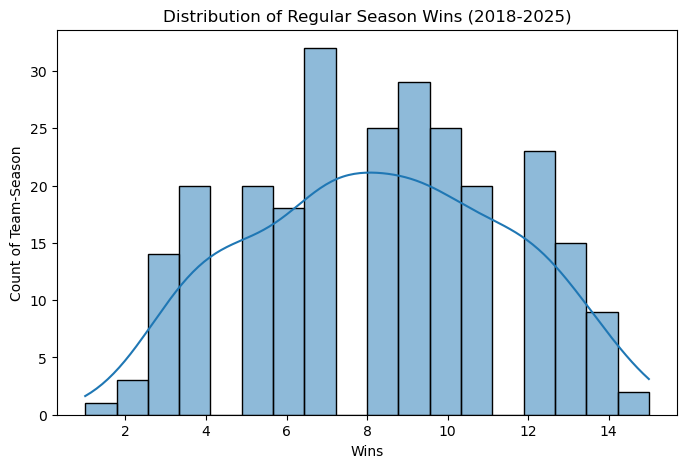

In [33]:
plt.figure(figsize=(8,5))

sns.histplot(data=master_df, x='tp_W', bins=18, kde=True)

plt.title('Distribution of Regular Season Wins (2018-2025)')
plt.xlabel('Wins')
plt.ylabel('Count of Team-Season')
plt.show();

The KDE overlay reveals a near-normal distribution of wins centered around approximately 8–9 victories. The smooth density curve indicates that most teams cluster in the mid-range, with relatively thin tails representing extreme underperformance or elite success. This distributional structure suggests playoff qualification decisions likely hinge on marginal differences among mid-tier teams rather than extreme outliers. There are relatively few teams at the extreames, with very low wins 1-3, and very high wins 13-15 occuring less frequently, which suggess that elite and bottom tier seasons are less common than mid tier outcomes.

We use a boxplot to examine the spread, central tendency, and potential outliers in regular season wins. This helps us understand how concentrated team performance is around the median and whether extreme seasons may influence modeling.

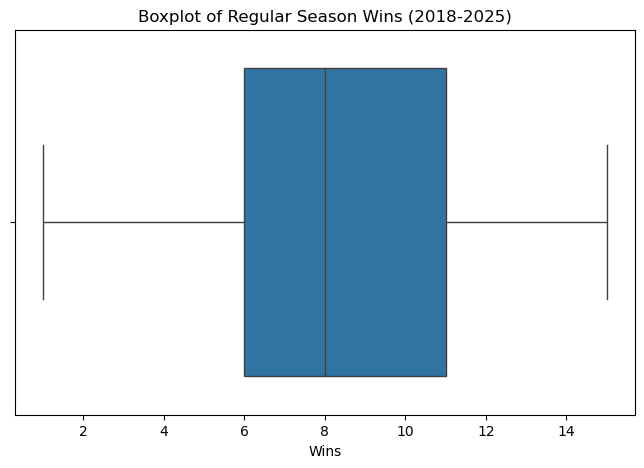

In [18]:
plt.figure(figsize=(8,5))

sns.boxplot(data=master_df, x='tp_W')
plt.title('Boxplot of Regular Season Wins (2018-2025)')
plt.xlabel('Wins')
plt.show();

The boxplot shows a median win total of approximately 8 wins, which aligns with the expectation that many teams finish near .500. The interquartile range appears to span roughly 6 to 11 wins, indicating that 50 percent of team-seasons fall within this competitive middle band.

The lower whisker extends to approximately 1–2 wins, while the upper whisker reaches approximately 15 wins, suggesting a wide but bounded distribution. There do not appear to be extreme statistical outliers beyond the whiskers, meaning most seasons fall within expected competitive limits.

This distribution confirms that win totals cluster tightly around the middle, reinforcing the idea that raw wins alone may not sufficiently differentiate team quality, especially among mid-tier teams. This supports the project’s objective of incorporating efficiency and contextual performance metrics beyond win–loss record.

Now, calculating the Overall Summary Stats for Wins (tp_W):

We calculate mean, median, and standard deviation to quantify the central tendency and variability of wins across all team-seasons. This helps determine whether the distribution is symmetric and how much spread exists around the average season outcome.


In [25]:
mean_wins = master_df['tp_W'].mean()
median_wins = master_df['tp_W'].median()
std_wins = master_df['tp_W'].std()

print('Mean Wins:', round(mean_wins, 2))
print("Median Wins:", median_wins)
print("Standard Deviation:", round(std_wins, 2))

Mean Wins: 8.28
Median Wins: 8.0
Standard Deviation: 3.17


According to the calculations above we can see the average wins per season is 8.28, with a median of 8.0 indicating that the distribution is approximately symmetric. The standard deviation of 3.17 suggests moderate varibility across team-seasons while most teams cluster around 5 and 11 wins and we see the meaningful sepration between the bottom and elite tier teams.

Calculating Wins by Season (Mean and Variance)

We group wins by season to assess whether league-level performance patterns shift over time, particularly before and after the transition from 16 to 17 regular-season games. Variance by season helps evaluate whether competitive balance changes year-to-year.

In [28]:
wins_by_season = master_df.groupby("season")["tp_W"].agg(["mean", "var"]).reset_index()

wins_by_season

,season,mean,var
0,2018,7.93750,8.383065
1,2019,7.96875,10.289315
2,2020,7.96875,12.224798
3,2021,8.46875,8.450605
4,2022,8.40625,9.603831
5,2023,8.50000,7.548387
6,2024,8.50000,13.741935
7,2025,8.46875,11.998992


We observe a modest increase from 2018-2020 16 game era to the 2021-2025 17 game era due to the addition of another game, suggesting the addition of the game did not dramatically change the league balance. While taking into account the variance we notice it is inconsistent across seasons possibly pointing towards relatively stable competetive teams over that time period.

Plotting the histogram and the KDE of Point differential (tp_pd) to determine if there is a level of domincance from certain teams spread across seasons. Unlike wins, point differantial captures scoring margin and may provide stronger separation between elite, and mid-tier teams. We are looking for skewness, clustering, and whether the distribution shows clear separation between strong and weak teams.

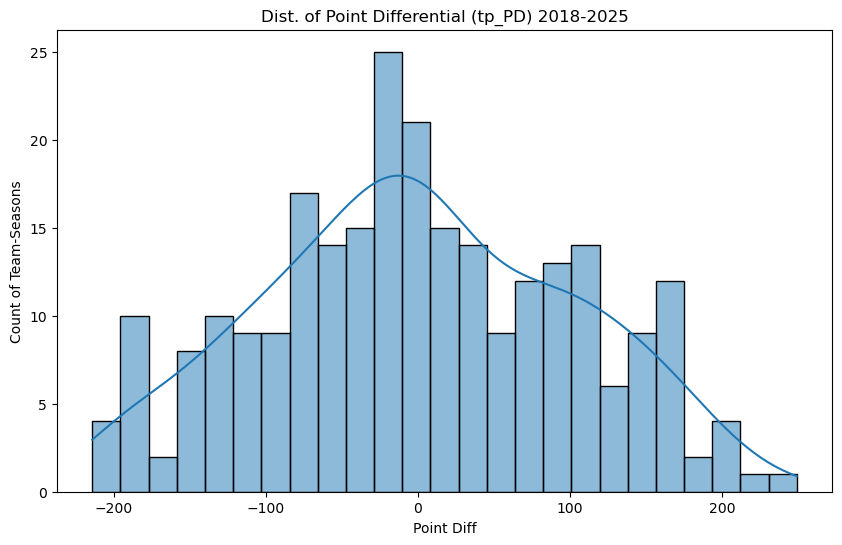

In [32]:
plt.figure(figsize=(10,6))

sns.histplot(data=master_df, x='tp_PD', bins=25, kde=True)
plt.title('Dist. of Point Differential (tp_PD) 2018-2025')
plt.xlabel('Point Diff')
plt.ylabel('Count of Team-Seasons')
plt.show()

We see the range extends from about -210 to +240 indicating substantial variability in team scoring dominance. Compared to wins the distribution is much more dispersed, suggesting that point differential captures finer-grained performance differances beyond simple wins. 

Creating a Bocplot of Point Differential to help visualize the spread and identify extreme seasons with unsually high or low scoring margins. We are examinging whether point differential shows greater dispersion than wins, which would support its use as a stronger predictive feature.

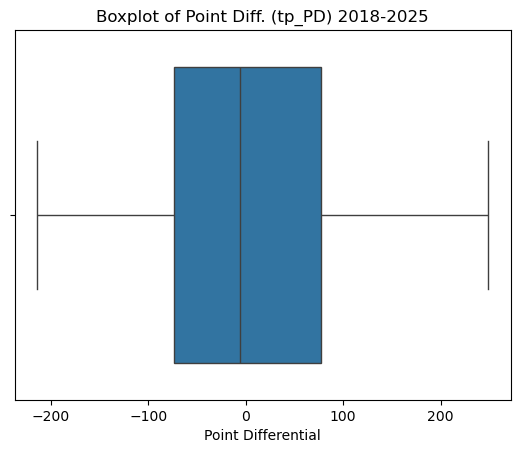

In [31]:
plt.Figure(figsize=(10,8))
sns.boxplot(data=master_df, x='tp_PD')
plt.title('Boxplot of Point Diff. (tp_PD) 2018-2025')
plt.xlabel('Point Differential')
plt.show()

Now creating a Scatter Plot of Wins Vs Point Differential to test the relationship is linear? vairance in wins similar to point differntial? and if some teams over/undder perform

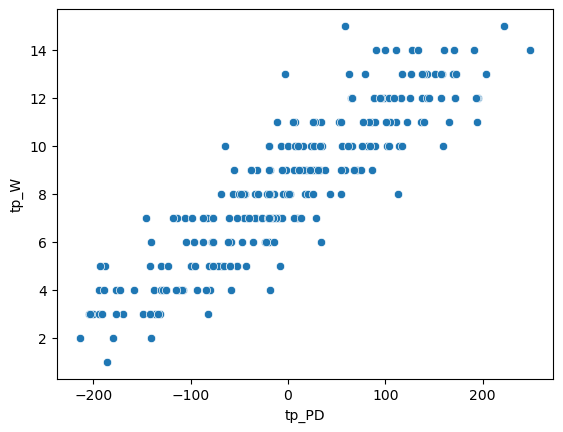

In [34]:
sns.scatterplot(data=master_df, x='tp_PD', y='tp_W')
plt.show()

Plotting distribution of offensive yards per play (off_yds_per_play)

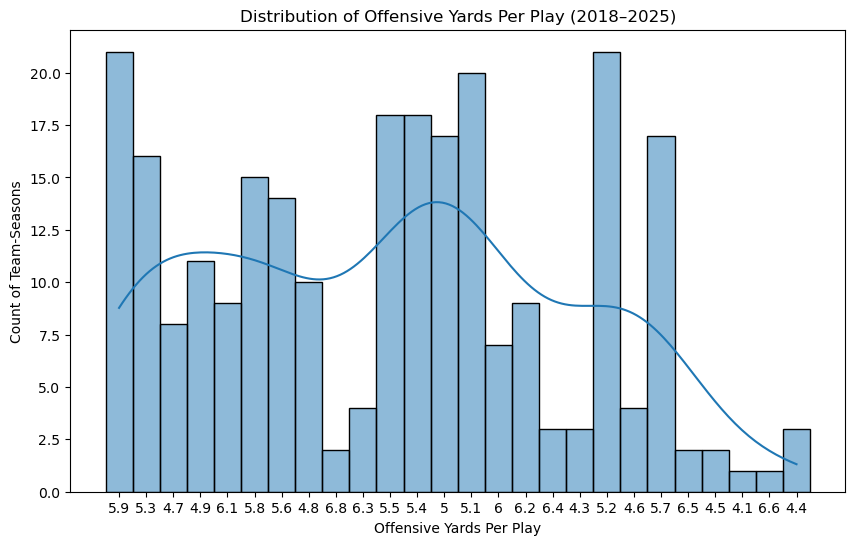

In [35]:
plt.figure(figsize=(10,6))
sns.histplot(data=master_df, x="off_yds_per_play", bins=20, kde=True)
plt.title("Distribution of Offensive Yards Per Play (2018–2025)")
plt.xlabel("Offensive Yards Per Play")
plt.ylabel("Count of Team-Seasons")
plt.show()

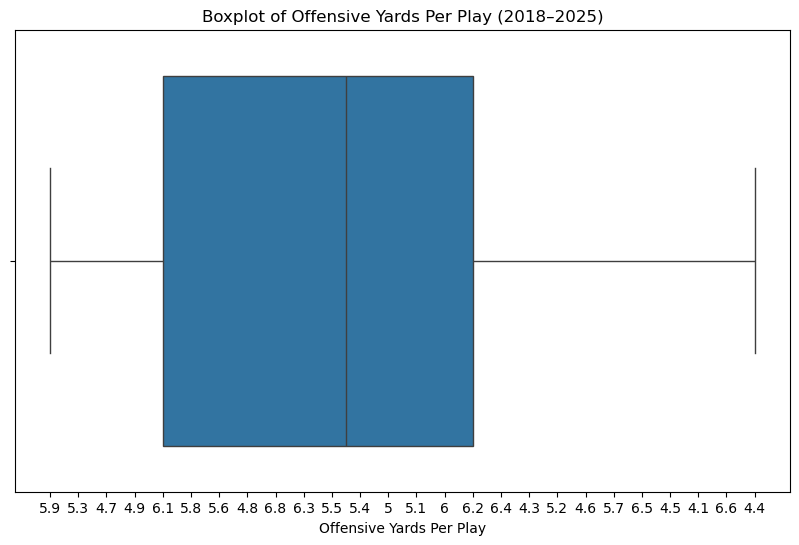

In [36]:
plt.figure(figsize=(10,6))
sns.boxplot(data=master_df, x="off_yds_per_play")
plt.title("Boxplot of Offensive Yards Per Play (2018–2025)")
plt.xlabel("Offensive Yards Per Play")
plt.show()

Offensive Point Scored (off_pts)

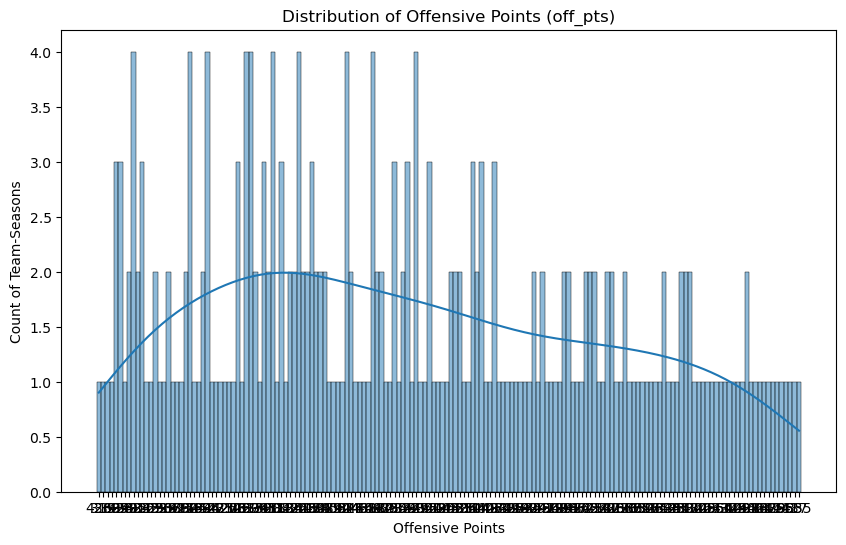

In [100]:
plt.figure(figsize=(10,6))
sns.histplot(data=master_df, x="off_pts", bins=20, kde=True)
plt.title("Distribution of Offensive Points (off_pts)")
plt.xlabel("Offensive Points")
plt.ylabel("Count of Team-Seasons")
plt.show()

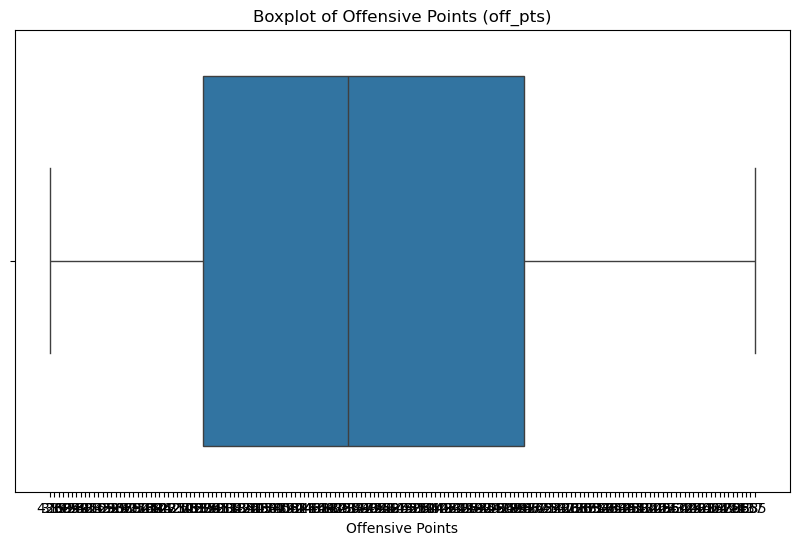

In [101]:
plt.figure(figsize=(10,6))
sns.boxplot(data=master_df, x="off_pts")
plt.title("Boxplot of Offensive Points (off_pts)")
plt.xlabel("Offensive Points")
plt.show()

In [54]:
print("Skewness (off_pts):", master_df["off_pts"].skew())

Skewness (off_pts): 0.199486318601598


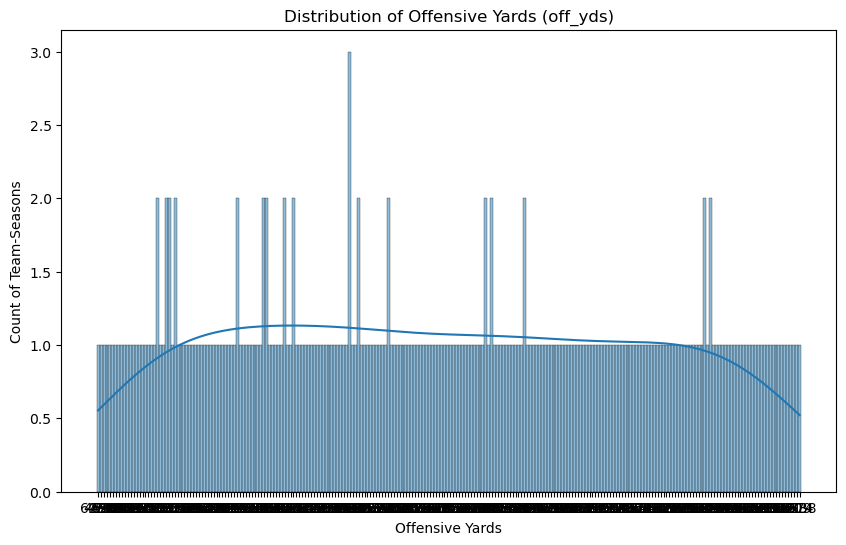

In [102]:
plt.figure(figsize=(10,6))
sns.histplot(data=master_df, x="off_yds", bins=20, kde=True)
plt.title("Distribution of Offensive Yards (off_yds)")
plt.xlabel("Offensive Yards")
plt.ylabel("Count of Team-Seasons")
plt.show()

off_yds (Total Offensive Yards)

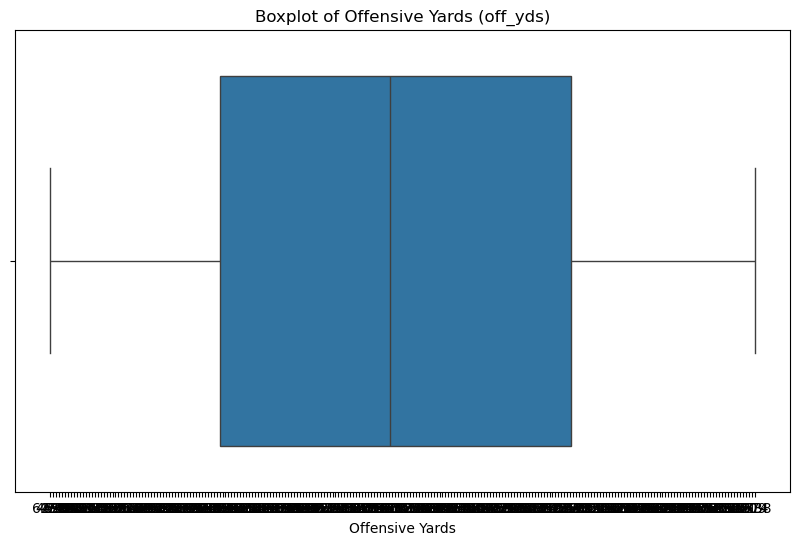

In [103]:
plt.figure(figsize=(10,6))
sns.boxplot(data=master_df, x='off_yds')
plt.title("Boxplot of Offensive Yards (off_yds)")
plt.xlabel("Offensive Yards")
plt.show()

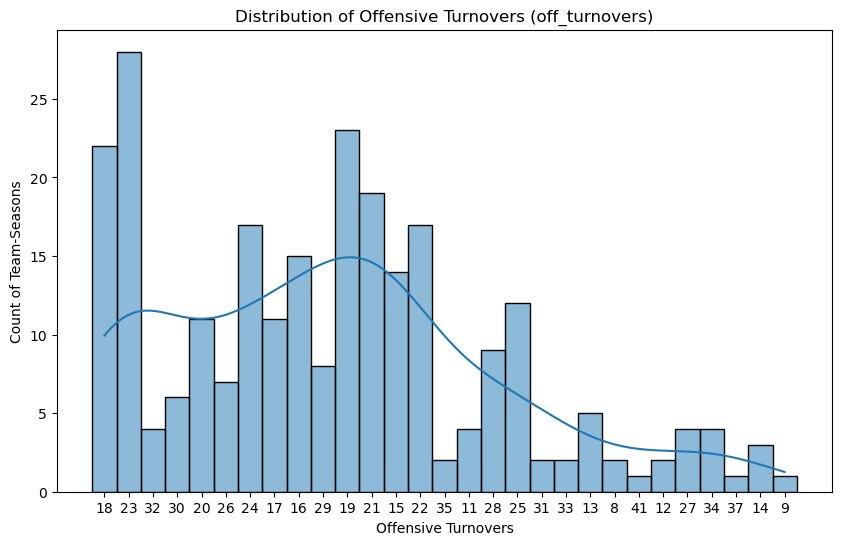

In [99]:
plt.figure(figsize=(10,6))
sns.histplot(data=master_df, x="off_turnovers", bins=20, kde=True)
plt.title("Distribution of Offensive Turnovers (off_turnovers)")
plt.xlabel("Offensive Turnovers")
plt.ylabel("Count of Team-Seasons")
plt.show()

off_turnovers

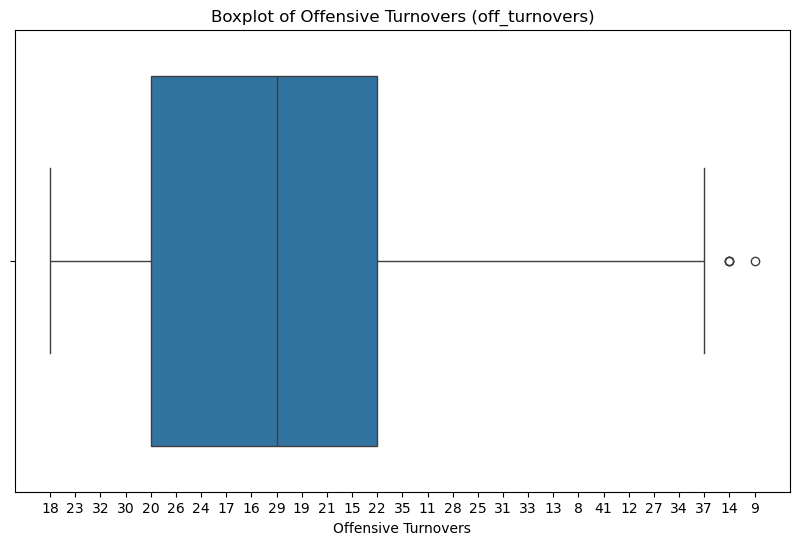

In [98]:
plt.figure(figsize=(10,6))
sns.boxplot(data=master_df, x="off_turnovers")
plt.title("Boxplot of Offensive Turnovers (off_turnovers)")
plt.xlabel("Offensive Turnovers")
plt.show()

off_score_pct (Scoring Percentage)

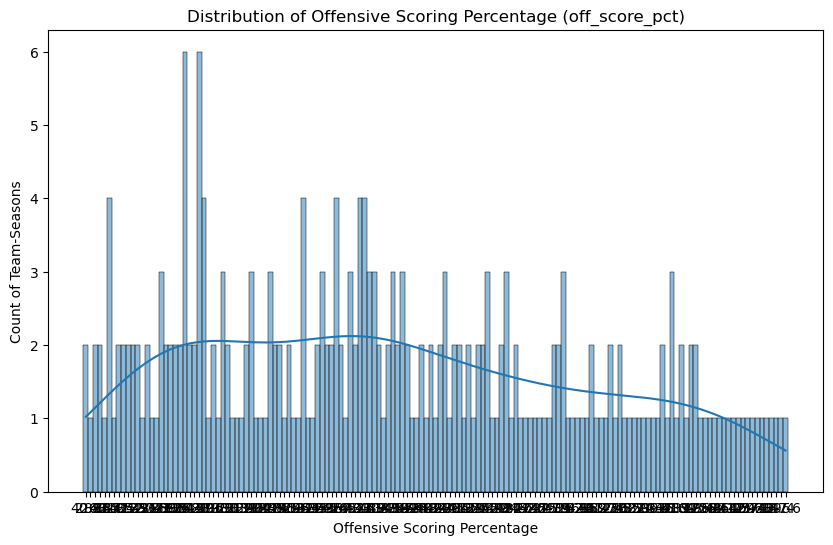

In [97]:
plt.figure(figsize=(10,6))
sns.histplot(data=master_df, x="off_score_pct", bins=20, kde=True)
plt.title("Distribution of Offensive Scoring Percentage (off_score_pct)")
plt.xlabel("Offensive Scoring Percentage")
plt.ylabel("Count of Team-Seasons")
plt.show()

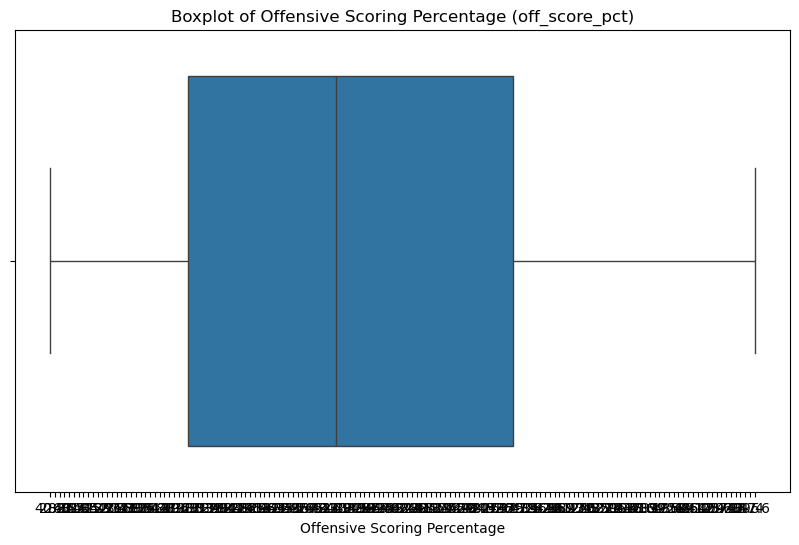

In [96]:
plt.figure(figsize=(10,6))
sns.boxplot(data=master_df, x="off_score_pct")
plt.title("Boxplot of Offensive Scoring Percentage (off_score_pct)")
plt.xlabel("Offensive Scoring Percentage")
plt.show()

off_turnover_pct

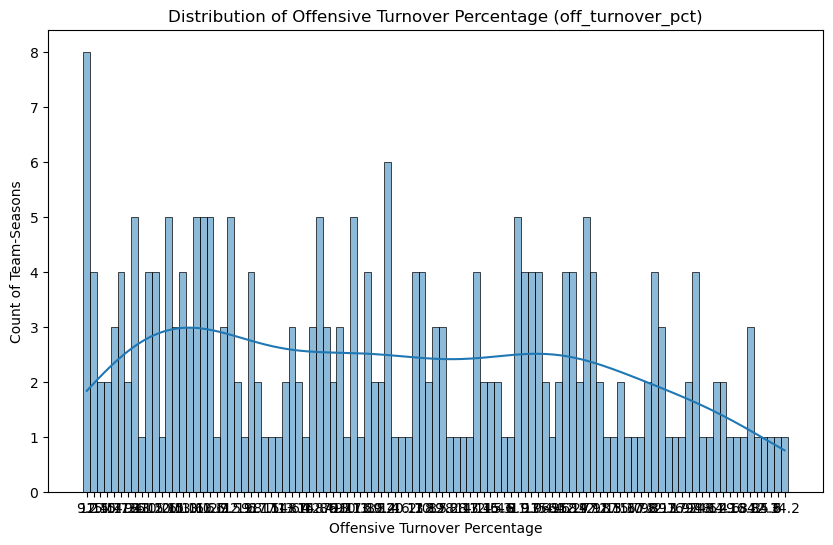

In [95]:
plt.figure(figsize=(10,6))
sns.histplot(data=master_df, x="off_turnover_pct", bins=20, kde=True)
plt.title("Distribution of Offensive Turnover Percentage (off_turnover_pct)")
plt.xlabel("Offensive Turnover Percentage")
plt.ylabel("Count of Team-Seasons")
plt.show()

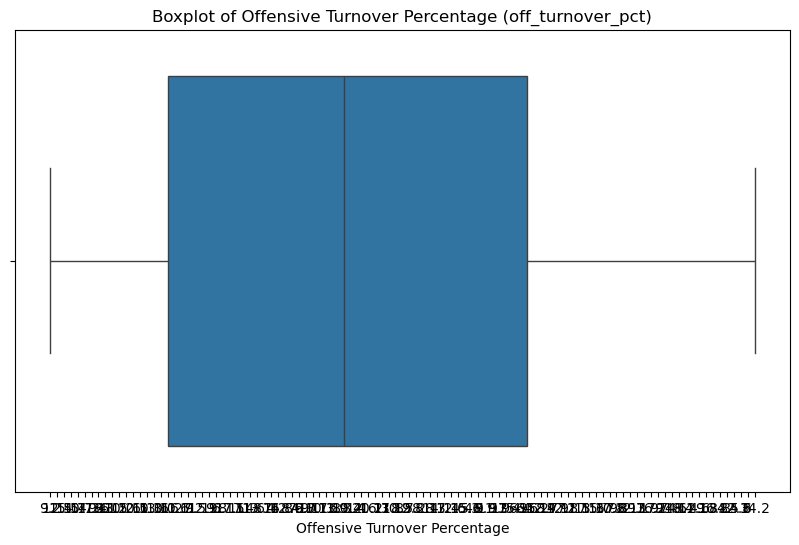

In [94]:
plt.figure(figsize=(10,6))
sns.boxplot(data=master_df, x="off_turnover_pct")
plt.title("Boxplot of Offensive Turnover Percentage (off_turnover_pct)")
plt.xlabel("Offensive Turnover Percentage")
plt.show()

off_exp (Expected Points Contribution)

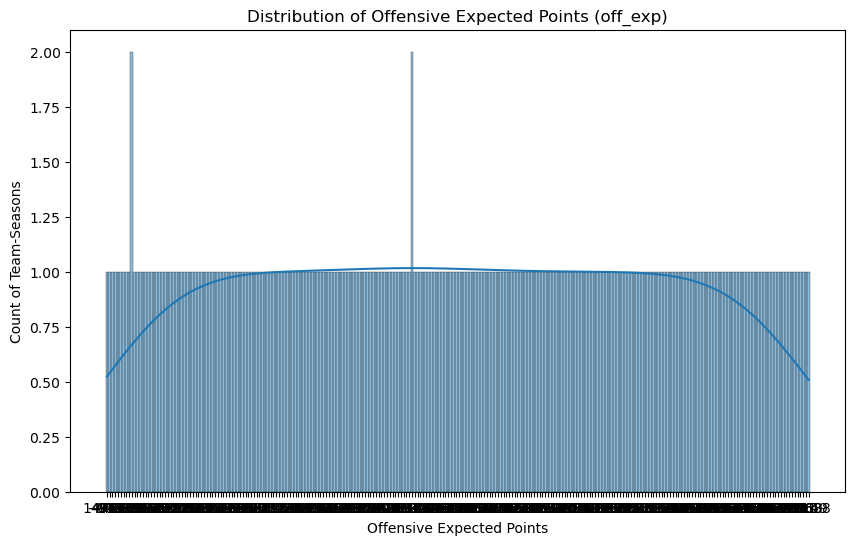

In [93]:
plt.figure(figsize=(10,6))
sns.histplot(data=master_df, x="off_exp", bins=20, kde=True)
plt.title("Distribution of Offensive Expected Points (off_exp)")
plt.xlabel("Offensive Expected Points")
plt.ylabel("Count of Team-Seasons")
plt.show()

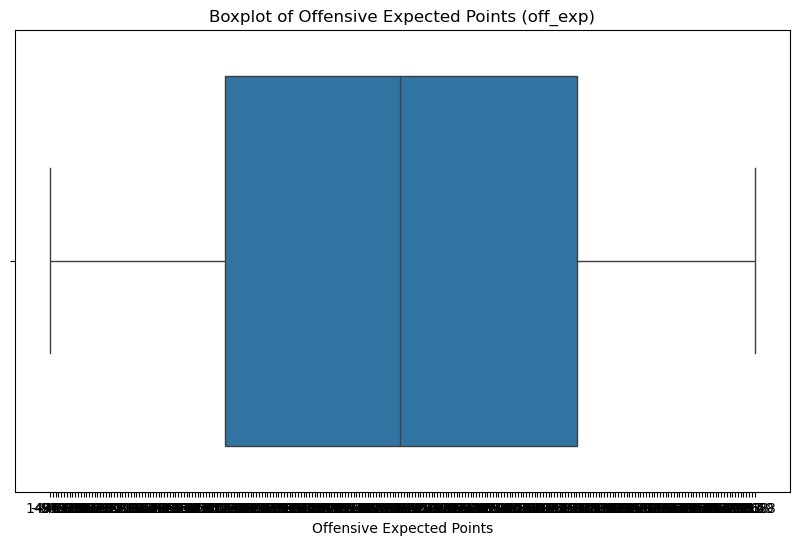

In [90]:
plt.figure(figsize=(10,6))
sns.boxplot(data=master_df, x="off_exp")
plt.title("Boxplot of Offensive Expected Points (off_exp)")
plt.xlabel("Offensive Expected Points")
plt.show()

Points Allowed def_pa

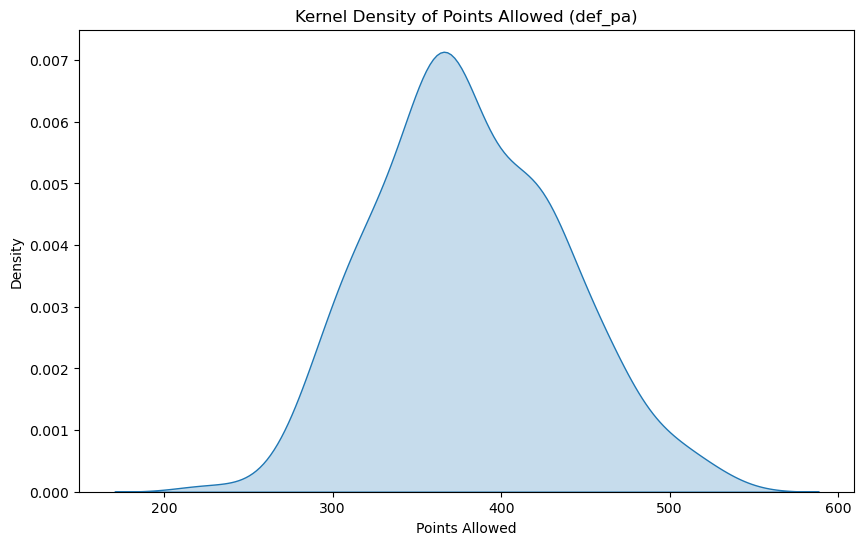

In [72]:
plt.figure(figsize=(10,6))
sns.kdeplot(data=master_df, x="def_pa", fill=True)
plt.title("Kernel Density of Points Allowed (def_pa)")
plt.xlabel("Points Allowed")
plt.ylabel("Density")
plt.show()

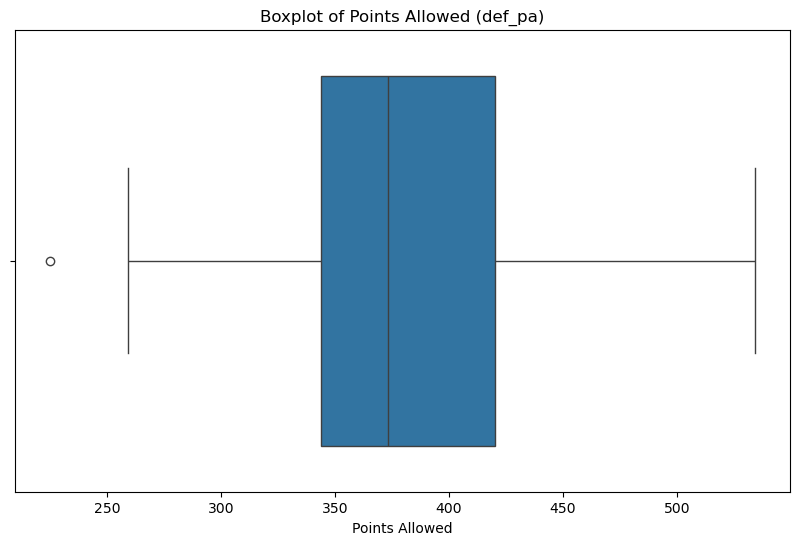

In [89]:
plt.figure(figsize=(10,6))
sns.boxplot(data=master_df, x="def_pa")
plt.title("Boxplot of Points Allowed (def_pa)")
plt.xlabel("Points Allowed")
plt.show()

In [74]:
print("Skewness (def_pa):", master_df["def_pa"].skew())


Skewness (def_pa): 0.23038499266257662


In [75]:
Q1 = master_df["def_pa"].quantile(0.25)
Q3 = master_df["def_pa"].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = master_df[(master_df["def_pa"] < lower_bound) | 
                     (master_df["def_pa"] > upper_bound)]

print("Number of outliers (def_pa):", len(outliers))

Number of outliers (def_pa): 1


def_yds_allowed

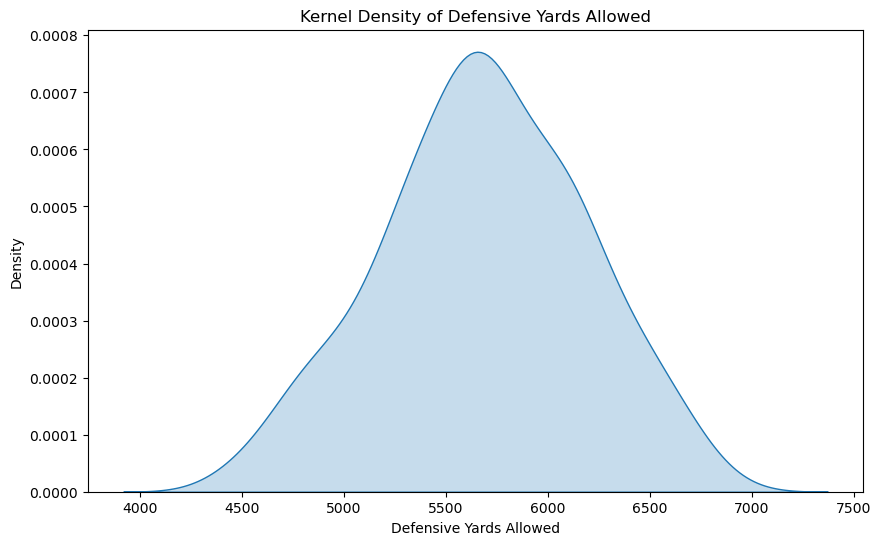

In [76]:
plt.figure(figsize=(10,6))
sns.kdeplot(data=master_df, x="def_yds_allowed", fill=True)
plt.title("Kernel Density of Defensive Yards Allowed")
plt.xlabel("Defensive Yards Allowed")
plt.ylabel("Density")
plt.show()

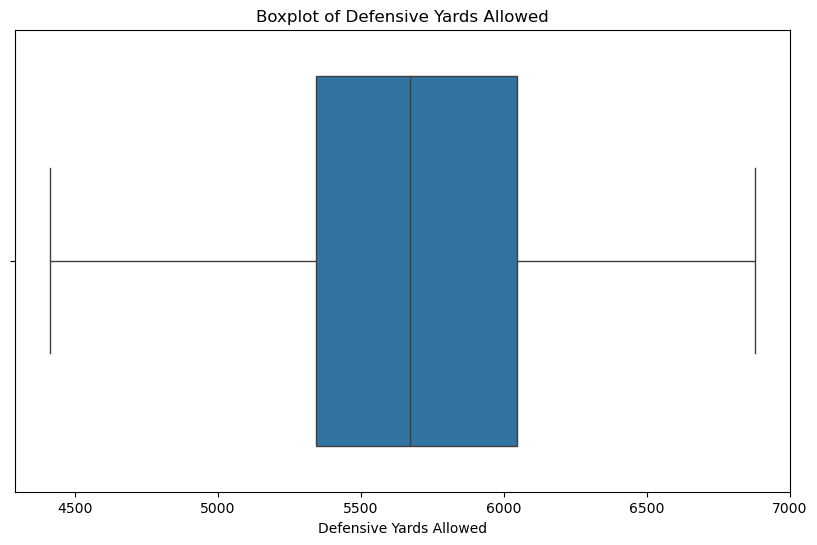

In [88]:
plt.figure(figsize=(10,6))
sns.boxplot(data=master_df, x="def_yds_allowed")
plt.title("Boxplot of Defensive Yards Allowed")
plt.xlabel("Defensive Yards Allowed")
plt.show()

def_yds_per_play

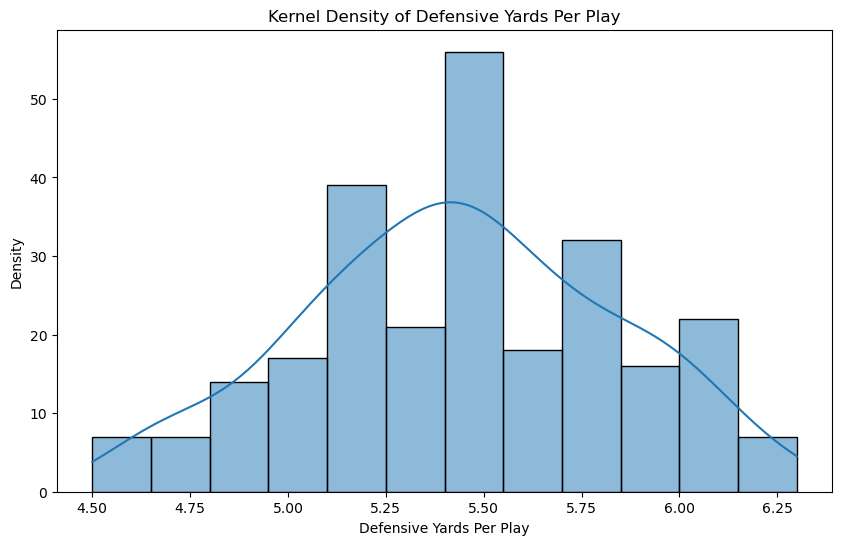

In [80]:
plt.figure(figsize=(10,6))
sns.histplot(data=master_df, x="def_yds_per_play", kde=True)
plt.title("Kernel Density of Defensive Yards Per Play")
plt.xlabel("Defensive Yards Per Play")
plt.ylabel("Density")
plt.show()

def_turnovers_forced

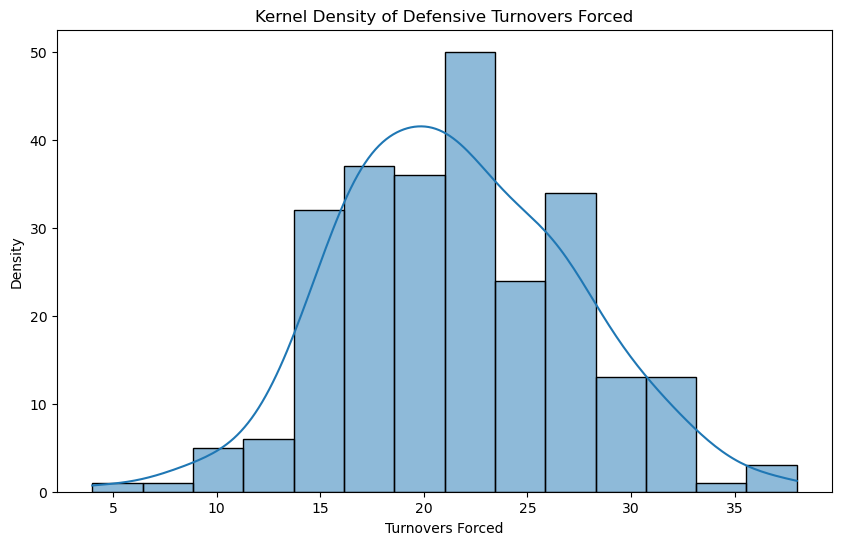

In [83]:
plt.figure(figsize=(10,6))
sns.histplot(data=master_df, x="def_turnovers_forced", kde=True)
plt.title("Kernel Density of Defensive Turnovers Forced")
plt.xlabel("Turnovers Forced")
plt.ylabel("Density")
plt.show()

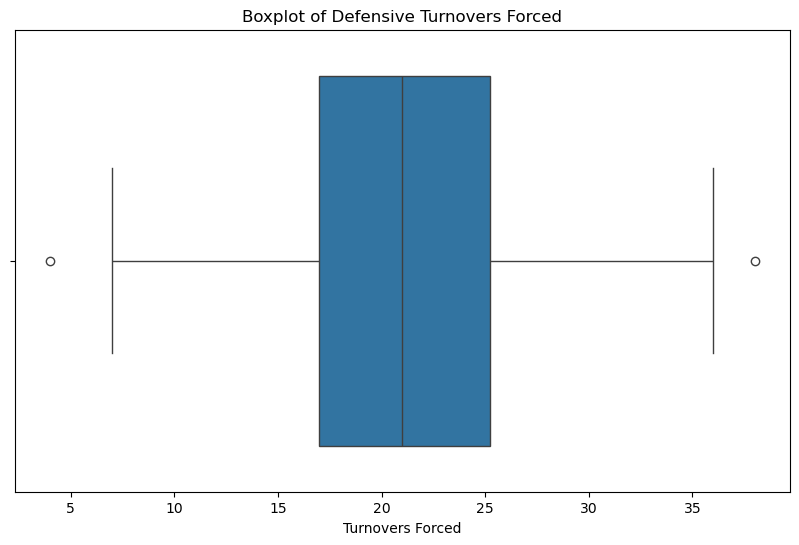

In [87]:
plt.figure(figsize=(10,6))
sns.boxplot(data=master_df, x="def_turnovers_forced")
plt.title("Boxplot of Defensive Turnovers Forced")
plt.xlabel("Turnovers Forced")
plt.show()

def_penalty_yds

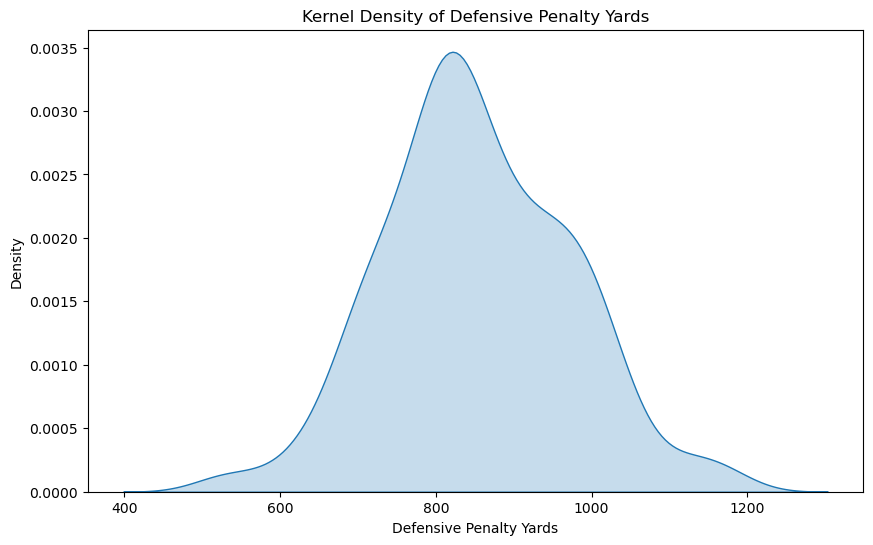

In [84]:
plt.figure(figsize=(10,6))
sns.kdeplot(data=master_df, x="def_penalty_yds", fill=True)
plt.title("Kernel Density of Defensive Penalty Yards")
plt.xlabel("Defensive Penalty Yards")
plt.ylabel("Density")
plt.show()

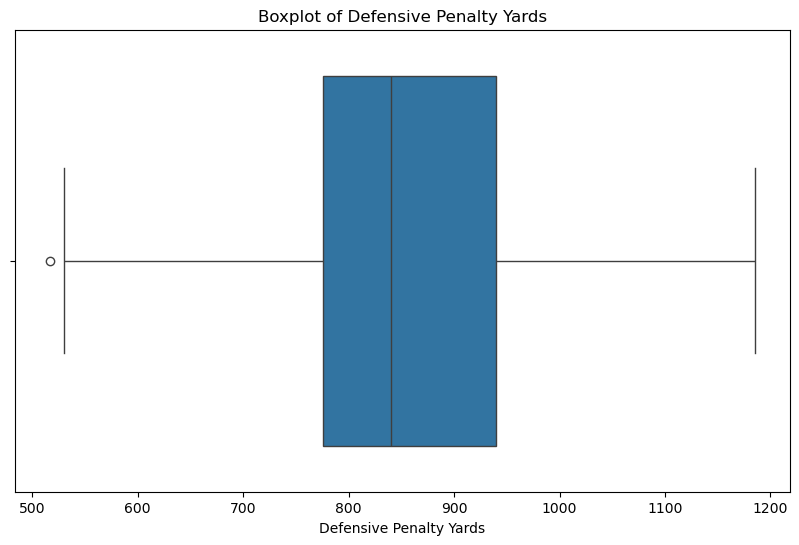

In [85]:
plt.figure(figsize=(10,6))
sns.boxplot(data=master_df, x="def_penalty_yds")
plt.title("Boxplot of Defensive Penalty Yards")
plt.xlabel("Defensive Penalty Yards")
plt.show()

def_exp (Defensive Expected Points Contribution)

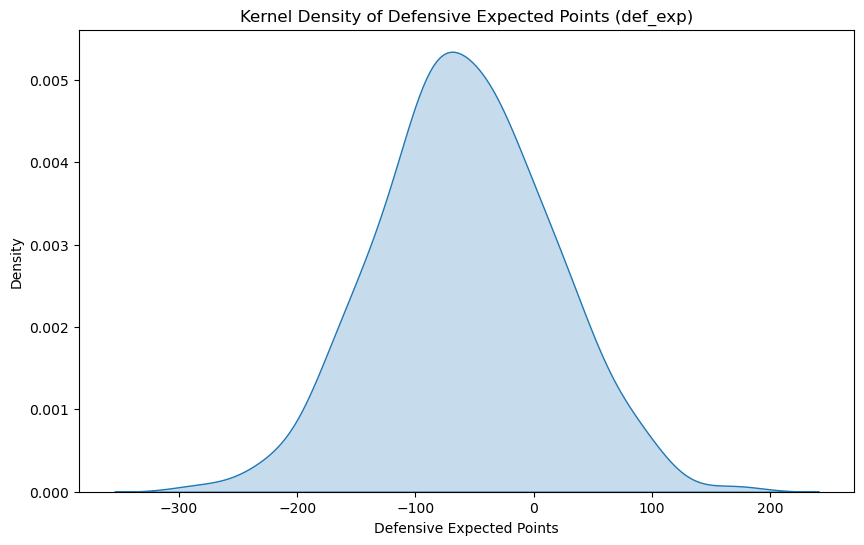

In [104]:
plt.figure(figsize=(10,6))
sns.kdeplot(data=master_df, x="def_exp", fill=True)
plt.title("Kernel Density of Defensive Expected Points (def_exp)")
plt.xlabel("Defensive Expected Points")
plt.ylabel("Density")
plt.show()

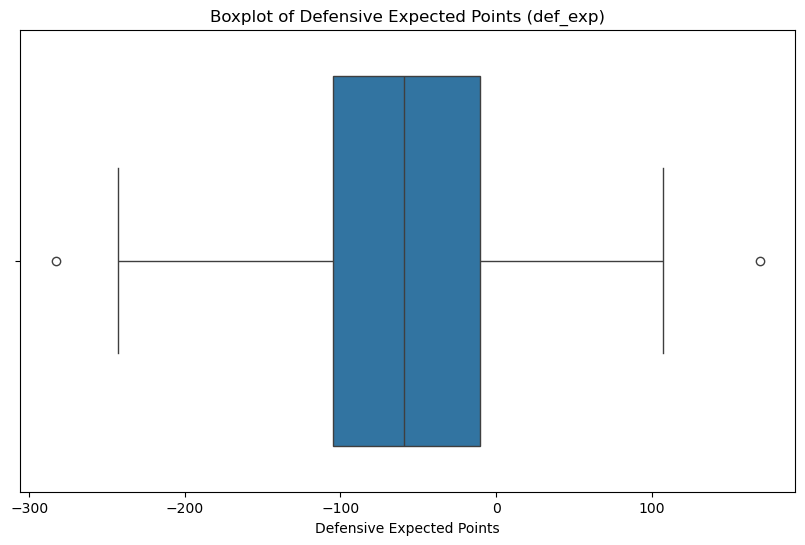

In [105]:
plt.figure(figsize=(10,6))
sns.boxplot(x=master_df["def_exp"])
plt.title("Boxplot of Defensive Expected Points (def_exp)")
plt.xlabel("Defensive Expected Points")
plt.show()